# Anomaly Prediction using Random Forest

## A. Input Data dan Eksplorasi Data Awal

### 1-Distribusi Keterangan Meter

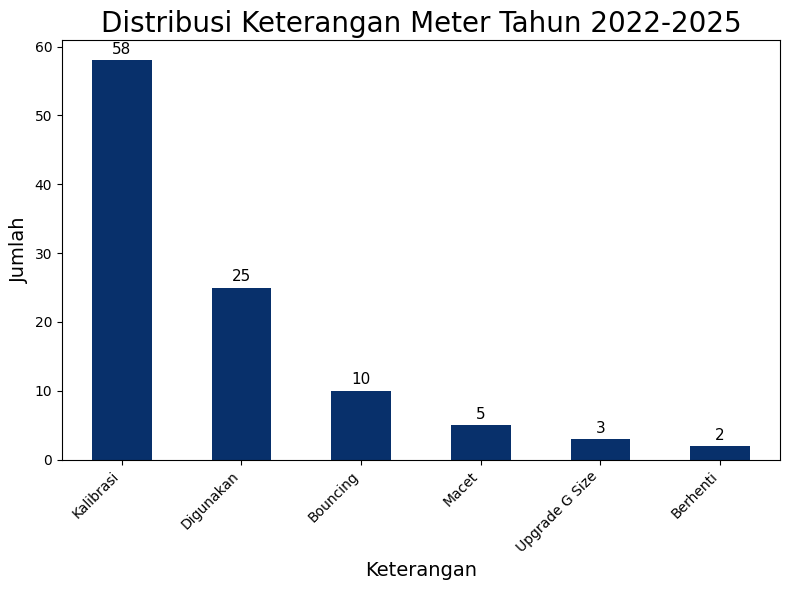

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data dari sheet "tabtab"
df = pd.read_excel('/content/Data Meter Update-clean.xlsx', sheet_name='tabtab')
df.columns = df.columns.astype(str)

# Menghitung distribusi kategori di kolom 'Keterangan'
keterangan_counts = df['Keterangan'].value_counts()

# Visualisasi distribusi dalam bentuk bar chart
plt.figure(figsize=(8, 6))
ax = keterangan_counts.plot(kind='bar', color='#08306b')

# Menambahkan judul dan label (judul diperbesar)
plt.title('Distribusi Keterangan Meter Tahun 2022-2025', fontsize=20)
plt.xlabel('Keterangan', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Agar teks label x-axis lebih mudah dibaca

# Menambahkan jumlah di atas tiap batang
for i, v in enumerate(keterangan_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=11)

plt.tight_layout()

# Menampilkan chart
plt.show()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   No                      103 non-null    int64         
 1   SERIAL NUMBER meter     103 non-null    object        
 2   MERK METER              103 non-null    object        
 3   JENIS meter             103 non-null    object        
 4   TAHUN meter             103 non-null    int64         
 5   G SIZE meter            103 non-null    int64         
 6   DIA. (inchi) meter      103 non-null    int64         
 7   Nama Pelanggan          103 non-null    object        
 8   Tanggal ganti meter     103 non-null    datetime64[ns]
 9   Keterangan              103 non-null    object        
 10  Lama Pemakaian          103 non-null    int64         
 11  Rekomendasi Penggunaan  26 non-null     float64       
 12  Akurasi                 28 non-null     float64   

### 2- Distribusi Data Kategorik

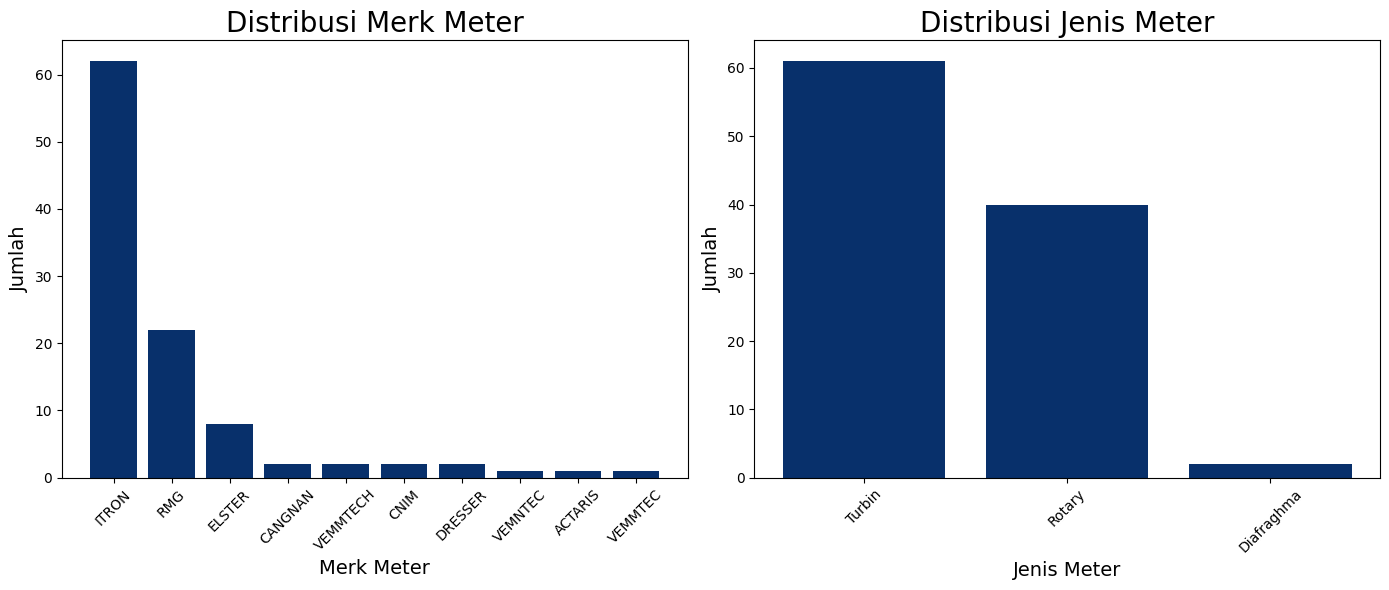

In [3]:
# Menghitung distribusi untuk kolom 'MERK METER' dan 'JENIS METER'
merk_meter_counts = df['MERK METER'].value_counts()
jenis_meter_counts = df['JENIS meter'].value_counts()

# Menyusun plot untuk Merk Meter
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Membuat 2 subplot untuk bar chart berdampingan

# Bar chart untuk Merk Meter
axes[0].bar(merk_meter_counts.index, merk_meter_counts.values, color='#08306b')
axes[0].set_title('Distribusi Merk Meter', fontsize=20)  # ukuran judul diperbesar
axes[0].set_xlabel('Merk Meter', fontsize=14)
axes[0].set_ylabel('Jumlah', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Bar chart untuk Jenis Meter
axes[1].bar(jenis_meter_counts.index, jenis_meter_counts.values, color='#08306b')
axes[1].set_title('Distribusi Jenis Meter', fontsize=20)  # ukuran judul diperbesar
axes[1].set_xlabel('Jenis Meter', fontsize=14)
axes[1].set_ylabel('Jumlah', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Menyempurnakan layout
plt.tight_layout()

# Menampilkan chart
plt.show()

## B. Distribusi Nilai Berdasarkan Kondisi

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data
df = pd.read_excel('/content/Data Meter Update-clean.xlsx', sheet_name='inti')
df.columns = df.columns.astype(str)
df.drop(columns=['No', 'Keterangan', 'Keterangan FIX', 'Total'], inplace=True, errors='ignore')

# Kolom tahun
year_cols = ['2022', '2023', '2024', '2025']
df[year_cols] = df[year_cols].fillna(-1).astype(int)

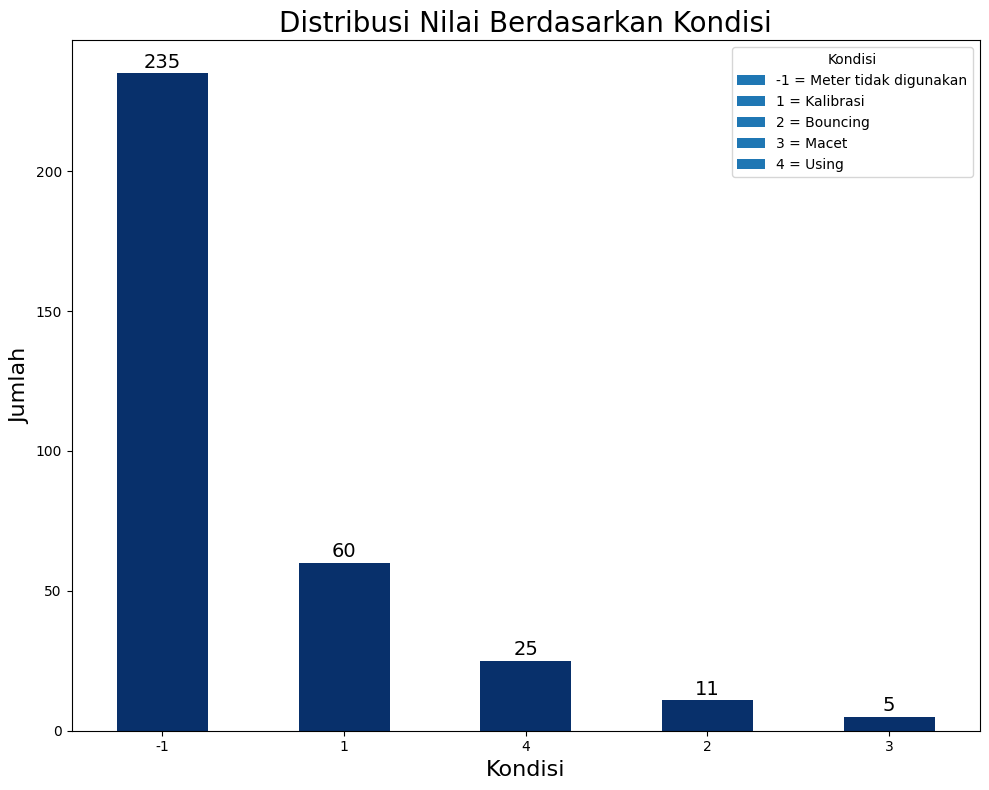

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Ambil semua nilai di kolom tahun dan ubah 0 jadi -1
all_years = df[year_cols].values.flatten()
all_years = np.where(all_years == 0, -1, all_years)  # Ganti 0 jadi -1

# Hitung distribusi nilai setelah penggantian
condition_counts = pd.Series(all_years).value_counts()

# Warna semua biru
bar_color = '#08306b'

# Plot bar chart
plt.figure(figsize=(10, 8))
bars = condition_counts.plot(kind='bar', color=bar_color)

# Menambahkan jumlah di atas setiap bar
for i, v in enumerate(condition_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=14)

# Judul dan label (judul diperbesar)
plt.title('Distribusi Nilai Berdasarkan Kondisi', fontsize=20)
plt.xlabel('Kondisi', fontsize=16)
plt.ylabel('Jumlah', fontsize=16)
plt.xticks(
    ticks=range(len(condition_counts)),
    labels=[str(i) for i in condition_counts.index],  # hanya angka
    rotation=0
)

# Legend dengan keterangan penuh
legend_handles = [
    mpatches.Patch(label='-1 = Meter tidak digunakan'),
    mpatches.Patch(label='1 = Kalibrasi'),
    mpatches.Patch(label='2 = Bouncing'),
    mpatches.Patch(label='3 = Macet'),
    mpatches.Patch(label='4 = Using')
]

plt.legend(handles=legend_handles, title="Kondisi", loc='upper right')
plt.tight_layout()
plt.show()

In [6]:
# Pastikan fitur kategori sudah di-encode dan ada dalam model
print(df[['2022', '2023', '2024', '2025']].head(35))

    2022  2023  2024  2025
0      1    -1    -1    -1
1     -1     1    -1    -1
2      1    -1    -1    -1
3      1    -1    -1    -1
4      2    -1    -1    -1
5      1    -1    -1    -1
6     -1     1     3    -1
7      1     2    -1    -1
8     -1     1    -1    -1
9      1    -1    -1    -1
10     1    -1    -1    -1
11     1    -1    -1    -1
12     1    -1    -1    -1
13     1    -1    -1    -1
14     1    -1     2     2
15     1    -1    -1    -1
16     1    -1    -1    -1
17     2    -1     2     4
18     1    -1    -1     1
19     1    -1    -1    -1
20     1     1    -1    -1
21     1    -1    -1    -1
22    -1     3     2     4
23    -1     1    -1    -1
24    -1     1    -1    -1
25    -1     1    -1    -1
26    -1     1    -1    -1
27    -1     1    -1    -1
28    -1     1    -1    -1
29    -1    -1     1    -1
30    -1     1    -1    -1
31    -1     1    -1    -1
32    -1     1     1     4
33    -1     3    -1    -1
34    -1     1    -1     2


In [7]:
# Melihat struktur data
df

,MERK METER,JENIS meter,TAHUN meter,G SIZE meter,DIA. (inchi) meter,SERIAL NUMBER meter,2022,2023,2024,2025,Kondisi Meter,usia
0,ITRON,Rotary,2016,25,2,'3402824608,1,-1,-1,-1,Baik,9
1,ITRON,Rotary,2015,25,2,'3402221548,-1,1,-1,-1,Baik,10
2,ITRON,Turbin,2013,100,3,'3401225996,1,-1,-1,-1,Baik,12
3,ITRON,Turbin,2011,65,2,'3400494265,1,-1,-1,-1,Baik,14
4,ITRON,Turbin,2013,250,4,'3401225518,2,-1,-1,-1,Warning 1,12
...,...,...,...,...,...,...,...,...,...,...,...,...
79,DRESSER,Turbin,2024,65,2,'3404606281,-1,-1,-1,1,Baik,1
80,ITRON,Rotary,2014,16,2,'3401671845,-1,-1,-1,4,Baik,11
81,ITRON,Rotary,2015,40,2,'3402221567,-1,-1,-1,4,Baik,10
82,ITRON,Turbin,2016,160,3,'3402824543/D,-1,-1,-1,4,Baik,9


## C. Pelabelan Data menggunakan Label Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Format long data
df_long = pd.melt(
    df,
    id_vars=['MERK METER', 'JENIS meter', 'TAHUN meter',
             'G SIZE meter', 'DIA. (inchi) meter', 'SERIAL NUMBER meter'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Condition'
)

df_long['Year'] = df_long['Year'].astype(int)
df_long['Usia Meter'] = df_long['Year'] - df_long['TAHUN meter']

# Inisialisasi OneHotEncoder (hanya untuk MERK & JENIS)
ohe_merk = OneHotEncoder(sparse_output=False)
ohe_jenis = OneHotEncoder(sparse_output=False)

# Melakukan One-Hot Encoding
merk_encoded = ohe_merk.fit_transform(df[['MERK METER']])
jenis_encoded = ohe_jenis.fit_transform(df[['JENIS meter']])

# Membuat DataFrame dari hasil encoding
df_merk = pd.DataFrame(merk_encoded, columns=ohe_merk.get_feature_names_out(['MERK METER']), index=df.index)
df_jenis = pd.DataFrame(jenis_encoded, columns=ohe_jenis.get_feature_names_out(['JENIS meter']), index=df.index)

# Gabungkan hasil One-Hot Encoding ke df (tetap simpan di df utama)
df = pd.concat([df, df_merk, df_jenis], axis=1)

# Gabungkan kolom hasil OHE ke df_long
df_long = df_long.merge(
    df[['SERIAL NUMBER meter'] + list(df_merk.columns) + list(df_jenis.columns)],
    on='SERIAL NUMBER meter',
    how='left'
)

# Menampilkan data setelah digabungkan
print("=== df dengan OHE ===")
print(df.head())

print("\n=== df_long dengan OHE ===")
print(df_long.head())

=== df dengan OHE ===
  MERK METER JENIS meter  TAHUN meter  G SIZE meter  DIA. (inchi) meter  \
0    ITRON      Rotary           2016            25                   2   
1    ITRON      Rotary           2015            25                   2   
2    ITRON      Turbin           2013           100                   3   
3    ITRON      Turbin           2011            65                   2   
4    ITRON      Turbin           2013           250                   4   

  SERIAL NUMBER meter  2022  2023  2024  2025  ... MERK METER_CNIM    \
0       '3402824608       1    -1    -1    -1  ...               0.0   
1       '3402221548      -1     1    -1    -1  ...               0.0   
2       '3401225996       1    -1    -1    -1  ...               0.0   
3       '3400494265       1    -1    -1    -1  ...               0.0   
4       '3401225518       2    -1    -1    -1  ...               0.0   

   MERK METER_DRESSER    MERK METER_ELSTER    MERK METER_ITRON    \
0                   0.0   

In [9]:
#Memastikan struktur data tidak berubah
df

,MERK METER,JENIS meter,TAHUN meter,G SIZE meter,DIA. (inchi) meter,SERIAL NUMBER meter,2022,2023,2024,2025,...,MERK METER_CNIM,MERK METER_DRESSER,MERK METER_ELSTER,MERK METER_ITRON,MERK METER_RMG,MERK METER_VEMTEC,MERK METER_VEMTECH,JENIS meter_Diapfragma,JENIS meter_Rotary,JENIS meter_Turbin
0,ITRON,Rotary,2016,25,2,'3402824608,1,-1,-1,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,ITRON,Rotary,2015,25,2,'3402221548,-1,1,-1,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ITRON,Turbin,2013,100,3,'3401225996,1,-1,-1,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,ITRON,Turbin,2011,65,2,'3400494265,1,-1,-1,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ITRON,Turbin,2013,250,4,'3401225518,2,-1,-1,-1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,DRESSER,Turbin,2024,65,2,'3404606281,-1,-1,-1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
80,ITRON,Rotary,2014,16,2,'3401671845,-1,-1,-1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
81,ITRON,Rotary,2015,40,2,'3402221567,-1,-1,-1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
82,ITRON,Turbin,2016,160,3,'3402824543/D,-1,-1,-1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Gabungkan label 2 & label 3 menjadi satu label => 2 (anomaly)
for col in year_cols:
    df[col] = df[col].replace({3: 2})

# Ubah nilai 4 menjadi -1 karena tidak digunakan
for col in year_cols:
    df[col] = df[col].replace({4: -1})

In [11]:
# Pastikan fitur kategori sudah di-encode dan ada dalam model
print(df.head(20))

   MERK METER JENIS meter  TAHUN meter  G SIZE meter  DIA. (inchi) meter  \
0     ITRON      Rotary           2016            25                   2   
1     ITRON      Rotary           2015            25                   2   
2     ITRON      Turbin           2013           100                   3   
3     ITRON      Turbin           2011            65                   2   
4     ITRON      Turbin           2013           250                   4   
5     ITRON      Turbin           2015           160                   4   
6     ITRON      Rotary           2015            25                   2   
7       RMG      Turbin           2014           100                   3   
8   CANGNAN      Rotary           2015            25                   2   
9     ITRON      Turbin           2013           250                   4   
10    ITRON      Rotary           2015            25                   2   
11   VEMTEC      Turbin           2011           400                   4   
12      RMG 

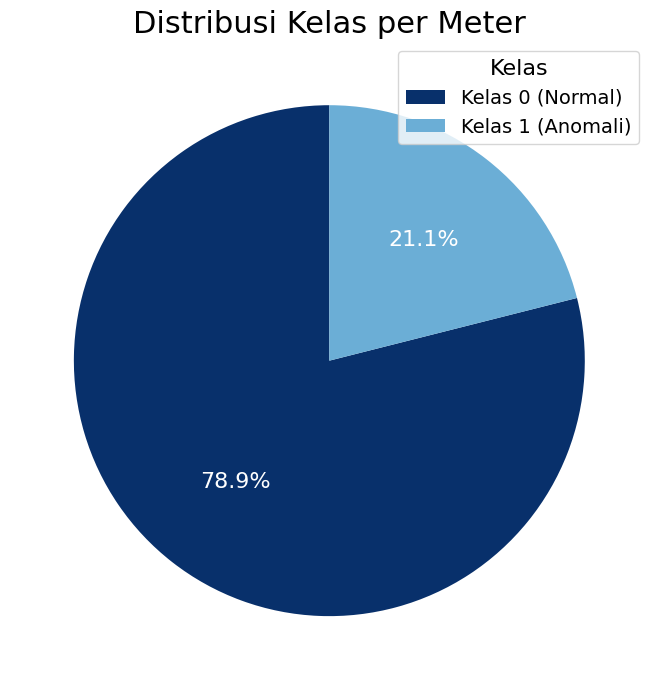

In [12]:
## Melihat Distribusi Kelas per Meter

import matplotlib.pyplot as plt
import pandas as pd

# Langkah 1: buat 'kelas_counts'
# Untuk mendeteksi kondisi meter (anomali vs normal)
# Ambil kolom 'Condition' dari df_long
df_long['Condition'] = df_long['Condition'].replace({3: 2, 4: -1})  # samakan mapping dengan df utama

# Buat kolom baru 'kelas': 0 = normal (Condition==1), 1 = anomali (Condition==2)
valid = df_long['Condition'].isin([1, 2])       # hanya ambil data valid
df_cls = df_long.loc[valid].copy()
df_cls['kelas'] = (df_cls['Condition'] == 2).astype(int)

# Hitung distribusi kelas
kelas_counts = df_cls['kelas'].value_counts().sort_index()  # hasil: 0 dan 1

# Langkah 2: visualisasi pie chart
plt.figure(figsize=(7,7))
colors = ['#08306b', '#6baed6']  # Warna untuk kelas 0 dan 1

wedges, texts, autotexts = plt.pie(
    kelas_counts.values,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Atur style persentase di pie chart
for a in autotexts:
    a.set_color('white')
    a.set_fontsize(16)

# Tambahkan legenda dengan ukuran lebih besar
plt.legend(
    wedges,
    ['Kelas 0 (Normal)', 'Kelas 1 (Anomali)'],
    title="Kelas",
    loc="best",
    fontsize=14,
    title_fontsize=16
)

# Judul lebih besar (tanpa bold)
plt.title("Distribusi Kelas per Meter", fontsize=22)

plt.tight_layout()
plt.show()

In [13]:
## Mengecek duplikat pada dataset

duplicates = df[df.duplicated()]

# Menampilkan data duplikat
print("Jumlah data duplikat:", len(duplicates))
print(duplicates)

Jumlah data duplikat: 0
Empty DataFrame
Columns: [MERK METER, JENIS meter, TAHUN meter, G SIZE meter, DIA. (inchi) meter, SERIAL NUMBER meter, 2022, 2023, 2024, 2025, Kondisi Meter, usia, MERK METER_ACTARIS  , MERK METER_CANGNAN  , MERK METER_CNIM  , MERK METER_DRESSER  , MERK METER_ELSTER  , MERK METER_ITRON  , MERK METER_RMG  , MERK METER_VEMTEC  , MERK METER_VEMTECH  , JENIS meter_Diapfragma  , JENIS meter_Rotary  , JENIS meter_Turbin  ]
Index: []

[0 rows x 24 columns]


## D. Pembagian Data Latih dan Data Uji

In [14]:
## Pembagian Data

from sklearn.model_selection import train_test_split

# Buat label: Baik (0) jika ada nilai 1 pada salah satu kolom tahun, selain itu Anomali (1)
df.loc[:, 'Kelas'] = df[year_cols].apply(lambda row: 0 if row.isin([1]).any() else 1, axis=1)

# Kolom OHE yang tersedia di df (sesuai daftar kolom kamu)
ohe_cols_merk  = [c for c in df.columns if c.startswith('MERK METER_')]
ohe_cols_jenis = [c for c in df.columns if c.startswith('JENIS meter_')]

# Fitur numerik yang ada + kolom tahun + OHE (tanpa G SIZE di-OHE karena sudah numerik)
feature_cols = (
    ['usia', 'TAHUN meter', 'G SIZE meter', 'DIA. (inchi) meter']  # numerik yang ada
    + year_cols                                                   # ['2022','2023','2024','2025']
    + ohe_cols_merk + ohe_cols_jenis                              # OHE dari MERK & JENIS
)

# X dan y
X = df[feature_cols]
y = df['Kelas']

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Melihat Pembagian Data Latih dan Data Uji
print(f'Jumlah data latih: {len(X_train)}')
print(f'Jumlah data uji: {len(X_test)}')

print("\nDistribusi Kelas pada Data Latih:")
print(y_train.value_counts())

print("\nDistribusi Kelas pada Data Uji:")
print(y_test.value_counts())

Jumlah data latih: 63
Jumlah data uji: 21

Distribusi Kelas pada Data Latih:
Kelas
0    41
1    22
Name: count, dtype: int64

Distribusi Kelas pada Data Uji:
Kelas
0    14
1     7
Name: count, dtype: int64


### 1-Visualisasi Data Latih dan Data Uji dalam Pie Chart

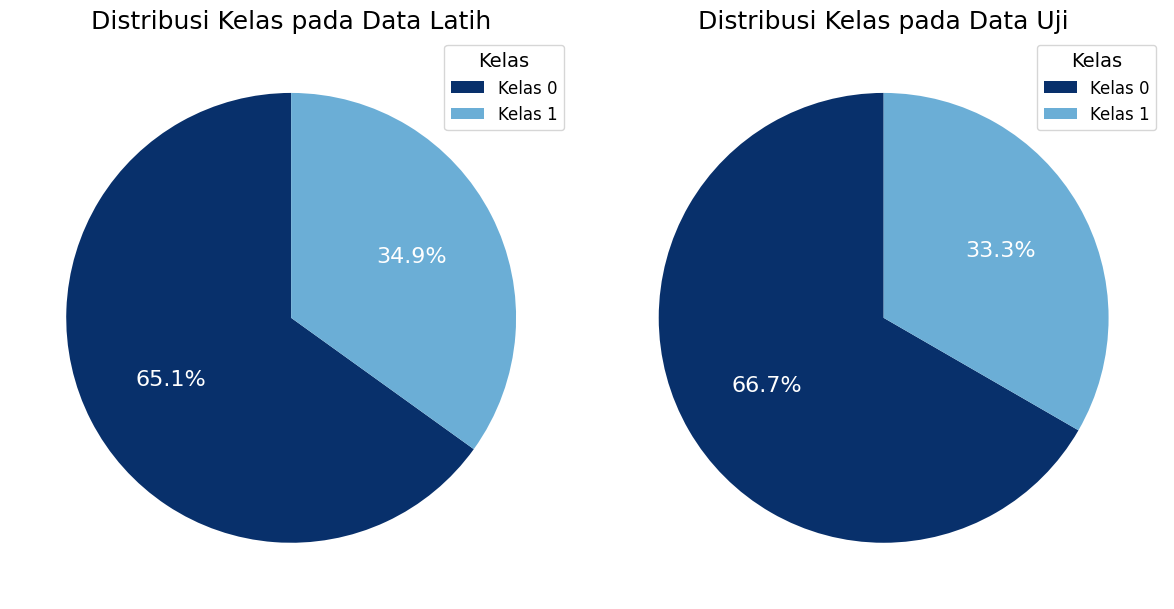

In [15]:
# Visualisasi Data Latih dan Data Uji dalam Pie Chart

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Pie chart untuk data latih
plt.subplot(1, 2, 1)
train_counts = y_train.value_counts().sort_index()
colors = ['#08306b', '#6baed6']  # warna untuk kelas 0 dan 1
wedges, texts, autotexts = plt.pie(
    train_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
for a in autotexts:
    a.set_color('white')
    a.set_fontsize(16)   # perbesar persentase tanpa bold
plt.title('Distribusi Kelas pada Data Latih', fontsize=18)  # judul diperbesar tanpa bold
plt.legend(wedges, [f'Kelas {i}' for i in train_counts.index],
           title="Kelas", loc="best", fontsize=12, title_fontsize=14)  # legenda diperbesar

# Pie chart untuk data uji
plt.subplot(1, 2, 2)
test_counts = y_test.value_counts().sort_index()
wedges, texts, autotexts = plt.pie(
    test_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
for a in autotexts:
    a.set_color('white')
    a.set_fontsize(16)   # perbesar persentase tanpa bold
plt.title('Distribusi Kelas pada Data Uji', fontsize=18)  # judul diperbesar tanpa bold
plt.legend(wedges, [f'Kelas {i}' for i in test_counts.index],
           title="Kelas", loc="best", fontsize=12, title_fontsize=14)  # legenda diperbesar

plt.tight_layout()
plt.show()

### 2-Head Data Latih dan Data Uji

In [16]:
# Menampilkan Data Latih
print("\nData Latih:")
print(X_train.head())  # Menampilkan 5 data teratas dari data latih

# Menampilkan Data Uji
print("\nData Uji:")
print(X_test.head())  # Menampilkan 5 data teratas dari data uji


Data Latih:
    usia  TAHUN meter  G SIZE meter  DIA. (inchi) meter  2022  2023  2024  \
43     3         2022           100                   3    -1    -1    -1   
80    11         2014            16                   2    -1    -1    -1   
14    18         2007          1600                   8     1    -1     2   
30    10         2015            65                   2    -1     1    -1   
33     8         2017            16                   2    -1     2    -1   

    2025  MERK METER_ACTARIS    MERK METER_CANGNAN    MERK METER_CNIM    \
43    -1                   0.0                   0.0                0.0   
80    -1                   0.0                   0.0                0.0   
14     2                   0.0                   0.0                0.0   
30    -1                   0.0                   0.0                0.0   
33    -1                   0.0                   0.0                0.0   

    MERK METER_DRESSER    MERK METER_ELSTER    MERK METER_ITRON    \
43  

## E. SMOTE Pada Data Latih

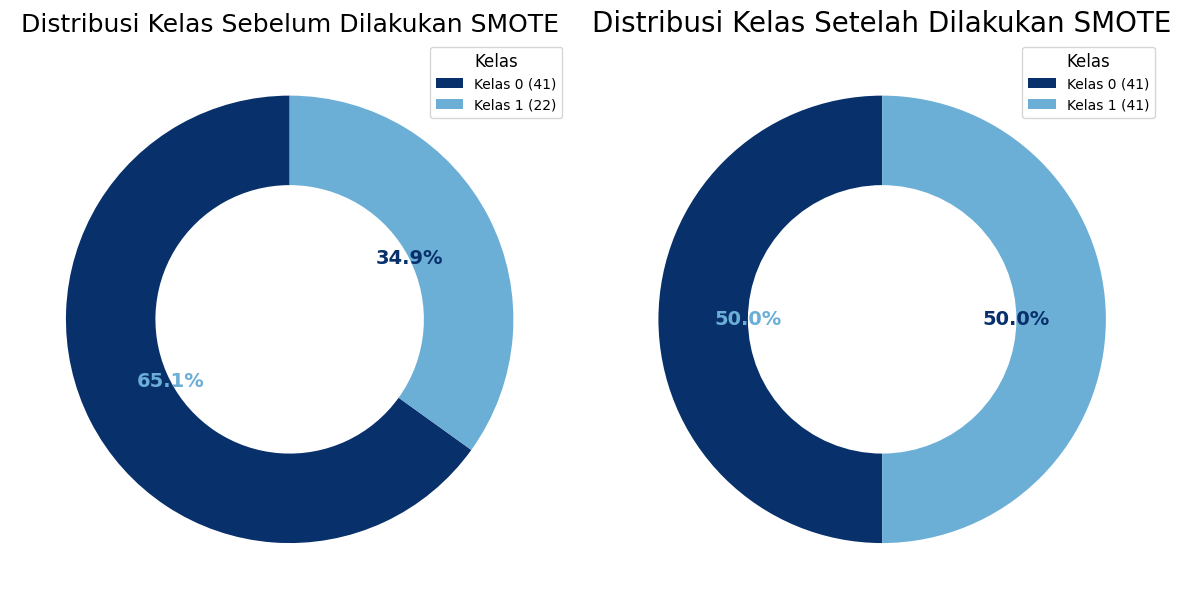

In [17]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

plt.figure(figsize=(12, 6))
colors = ['#08306b', '#6baed6']

# --- SEBELUM SMOTE ---
plt.subplot(1, 2, 1)
before_counts = y_train.value_counts().sort_index()

wedges, texts, autotexts = plt.pie(
    before_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

# Warna teks kebalikan dari warna slice
for w, a in zip(wedges, autotexts):
    facecolor = w.get_facecolor()
    if facecolor[:3] == (0.03137254901960784, 0.18823529411764706, 0.4196078431372549):  # #08306b
        a.set_color('#6baed6')  # teks biru muda
    else:
        a.set_color('#08306b')  # teks biru tua
    a.set_fontsize(14)
    a.set_fontweight("semibold")   # bikin agak bold

plt.title("Distribusi Kelas Sebelum Dilakukan SMOTE", fontsize=18)
plt.legend(
    wedges,
    [f'Kelas {i} ({before_counts[i]})' for i in before_counts.index],
    title="Kelas", loc="best", fontsize=10, title_fontsize=12
)

# --- SETELAH SMOTE ---
plt.subplot(1, 2, 2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
after_counts = y_train_smote.value_counts().sort_index()

wedges, texts, autotexts = plt.pie(
    after_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)

# Warna teks kebalikan dari warna slice
for w, a in zip(wedges, autotexts):
    facecolor = w.get_facecolor()
    if facecolor[:3] == (0.03137254901960784, 0.18823529411764706, 0.4196078431372549):  # #08306b
        a.set_color('#6baed6')  # teks biru muda
    else:
        a.set_color('#08306b')  # teks biru tua
    a.set_fontsize(14)
    a.set_fontweight("semibold")   # bikin agak bold


plt.title("Distribusi Kelas Setelah Dilakukan SMOTE", fontsize=20)
plt.legend(
    wedges,
    [f'Kelas {i} ({after_counts[i]})' for i in after_counts.index],
    title="Kelas", loc="best", fontsize=10, title_fontsize=12
)

plt.tight_layout()
plt.show()

### 1-Cek Duplikasi Data Setelah SMOTE

In [18]:
# Mengecek duplikat pada dataset
duplicates = df[df.duplicated()]

# Menampilkan data duplikat
print("Jumlah data duplikat:", len(duplicates))
print(duplicates)


Jumlah data duplikat: 0
Empty DataFrame
Columns: [MERK METER, JENIS meter, TAHUN meter, G SIZE meter, DIA. (inchi) meter, SERIAL NUMBER meter, 2022, 2023, 2024, 2025, Kondisi Meter, usia, MERK METER_ACTARIS  , MERK METER_CANGNAN  , MERK METER_CNIM  , MERK METER_DRESSER  , MERK METER_ELSTER  , MERK METER_ITRON  , MERK METER_RMG  , MERK METER_VEMTEC  , MERK METER_VEMTECH  , JENIS meter_Diapfragma  , JENIS meter_Rotary  , JENIS meter_Turbin  , Kelas]
Index: []

[0 rows x 25 columns]


### 2-Struktur Data Setelah SMOTE

In [19]:
print(df.head())

  MERK METER JENIS meter  TAHUN meter  G SIZE meter  DIA. (inchi) meter  \
0    ITRON      Rotary           2016            25                   2   
1    ITRON      Rotary           2015            25                   2   
2    ITRON      Turbin           2013           100                   3   
3    ITRON      Turbin           2011            65                   2   
4    ITRON      Turbin           2013           250                   4   

  SERIAL NUMBER meter  2022  2023  2024  2025  ... MERK METER_DRESSER    \
0       '3402824608       1    -1    -1    -1  ...                  0.0   
1       '3402221548      -1     1    -1    -1  ...                  0.0   
2       '3401225996       1    -1    -1    -1  ...                  0.0   
3       '3400494265       1    -1    -1    -1  ...                  0.0   
4       '3401225518       2    -1    -1    -1  ...                  0.0   

   MERK METER_ELSTER    MERK METER_ITRON    MERK METER_RMG    \
0                  0.0            

## F. Latih Model Random Forest + SMOTE

### 1-Pelatihan Model RF + SMOTE

In [20]:
import time
from sklearn.ensemble import RandomForestClassifier
classifier_rf_smote = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

### 2-Pengujian Terhadap OOB (Opsional)

In [21]:
classifier_rf_smote.oob_score_

0.8292682926829268

###3-Hyperparameter Tuning

In [22]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe_smote = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_jobs=-1, random_state=42,  # jangan set oob_score saat pakai SMOTE
    ))
])

param_grid_smote = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 8, 12, None],
    'clf__min_samples_leaf': [2, 3, 5],
    'clf__min_samples_split': [2, 4, 6],
    'clf__max_features': ['sqrt', 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_smote = GridSearchCV(
    estimator=pipe_smote,
    param_grid=param_grid_smote,
    scoring='accuracy',        # atau 'f1' / 'roc_auc' (binary) jika peduli imbalance
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search_smote.fit(X_train, y_train)  # <<< perhatikan: tanpa SMOTE di luar; SMOTE ada di Pipeline
print("Best params:", grid_search_smote.best_params_)
print("CV best score:", grid_search_smote.best_score_)
rf_best_smote = grid_search_smote.best_estimator_

## Menghitung Waktu Pelatihan Model RF + SMOTE
import time

start = time.time()
grid_search_smote.fit(X_train, y_train)
end = time.time()

print(f"Best params: {grid_search_smote.best_params_}")
print(f"CV best score: {grid_search_smote.best_score_:.4f}")
print(f"Waktu pelatihan: {(end - start)/60:.2f} menit")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best params: {'clf__max_depth': 5, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
CV best score: 0.8256410256410257
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best params: {'clf__max_depth': 5, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
CV best score: 0.8256
Waktu pelatihan: 8.54 menit


### 4- Parameter Terbaik

In [23]:
print(rf_best_smote)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(max_depth=5, max_features=0.5,
                                        min_samples_leaf=2, n_jobs=-1,
                                        random_state=42))])


### 5-Contoh Pohon Keputusan yang Terbentuk

Jumlah pohon dalam Random Forest: 100


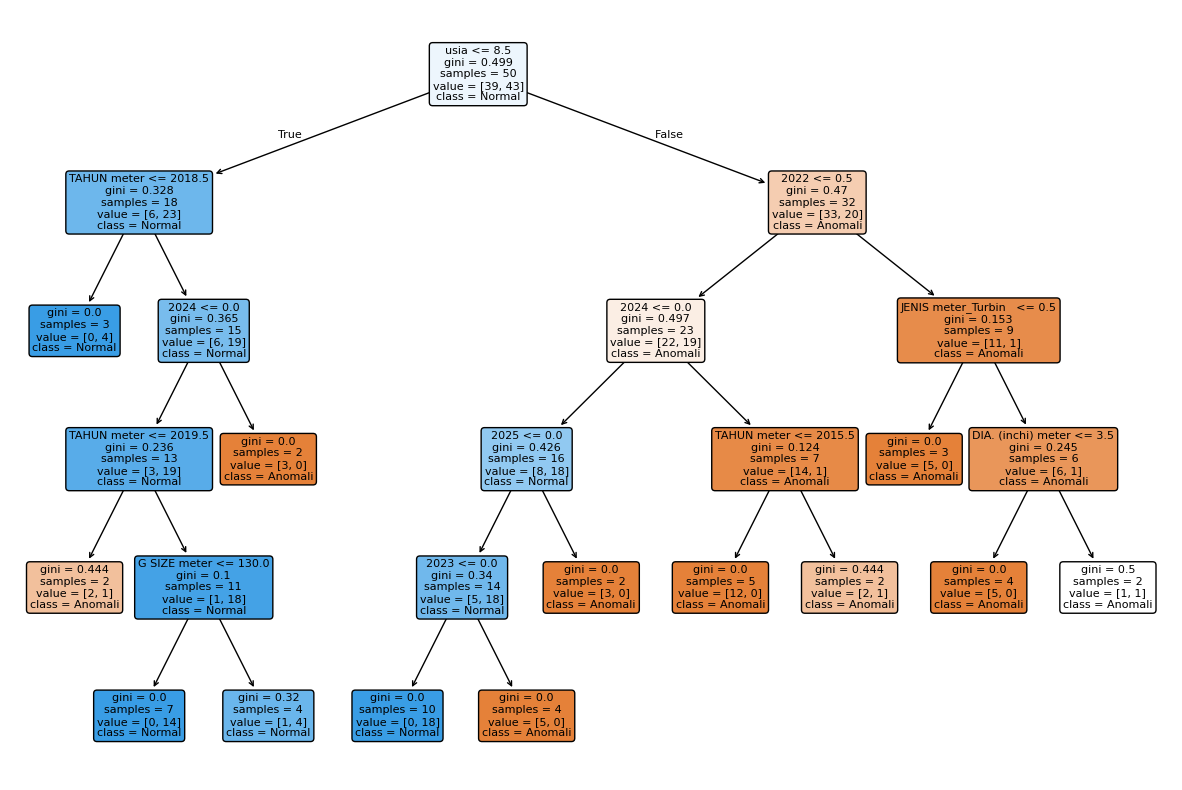

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# ambil RandomForestClassifier dari pipeline
rf_clf_smote = rf_best_smote.named_steps['clf']

# cek jumlah pohon
print(f"Jumlah pohon dalam Random Forest: {len(rf_clf_smote.estimators_)}")

# plot salah satu pohon, misalnya pohon ke-50
plt.figure(figsize=(15,10))
plot_tree(
    rf_clf_smote.estimators_[50],
    feature_names=X.columns,             # pastikan sesuai dengan kolom asli
    class_names=['Anomali', 'Normal'],   # label sesuai data
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


Jumlah pohon dalam Random Forest: 100


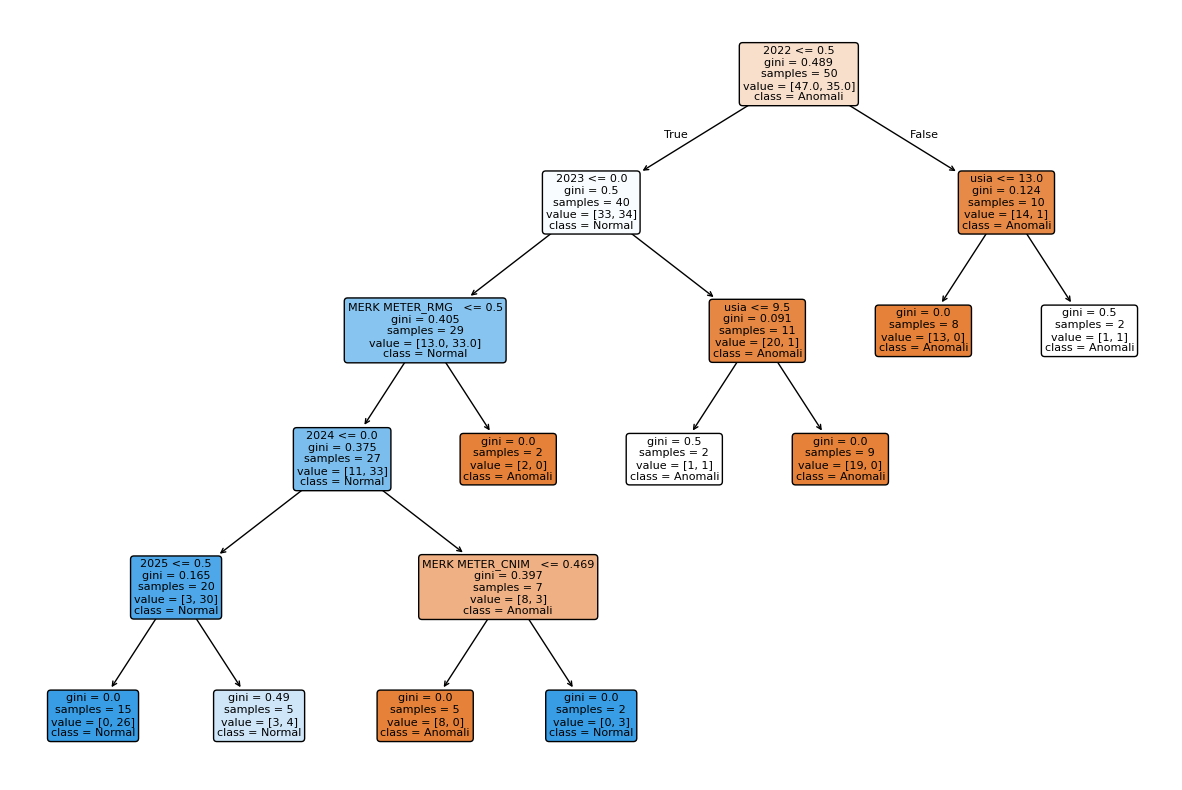

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# ambil RandomForestClassifier dari pipeline
rf_clf_smote = rf_best_smote.named_steps['clf']

# cek jumlah pohon
print(f"Jumlah pohon dalam Random Forest: {len(rf_clf_smote.estimators_)}")

# plot salah satu pohon, misalnya pohon ke-60
plt.figure(figsize=(15,10))
plot_tree(
    rf_clf_smote.estimators_[60],
    feature_names=X.columns,             # pastikan sesuai dengan kolom asli
    class_names=['Anomali', 'Normal'],   # label sesuai data
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


### 6-Evaluasi Model RF + SMOTE

Accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.50      0.57      0.53         7

    accuracy                           0.67        21
   macro avg       0.63      0.64      0.64        21
weighted avg       0.68      0.67      0.67        21


Confusion Matrix (urut label): [0 1]
[[10  4]
 [ 3  4]]

TP: 4, TN: 10, FP: 4, FN: 3

G-Mean: 0.6389
Youden's Index: 0.2857
AUC: 0.7143


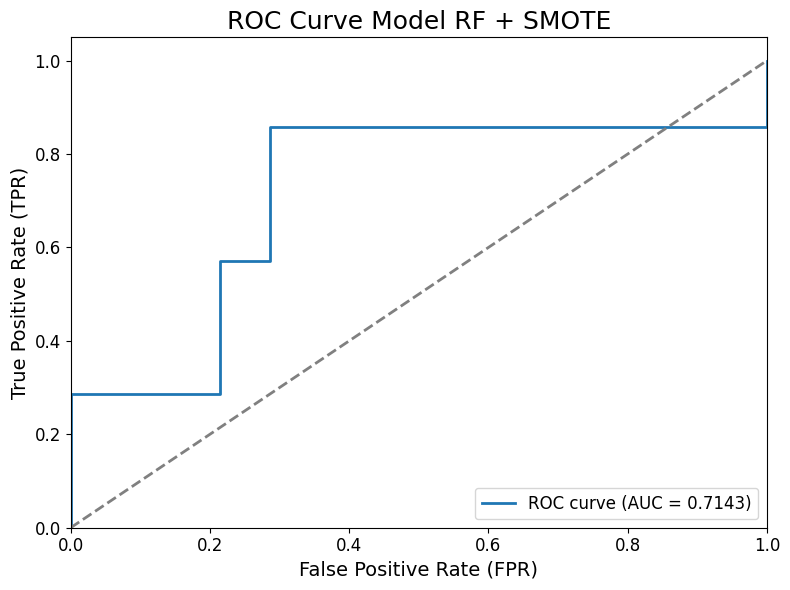

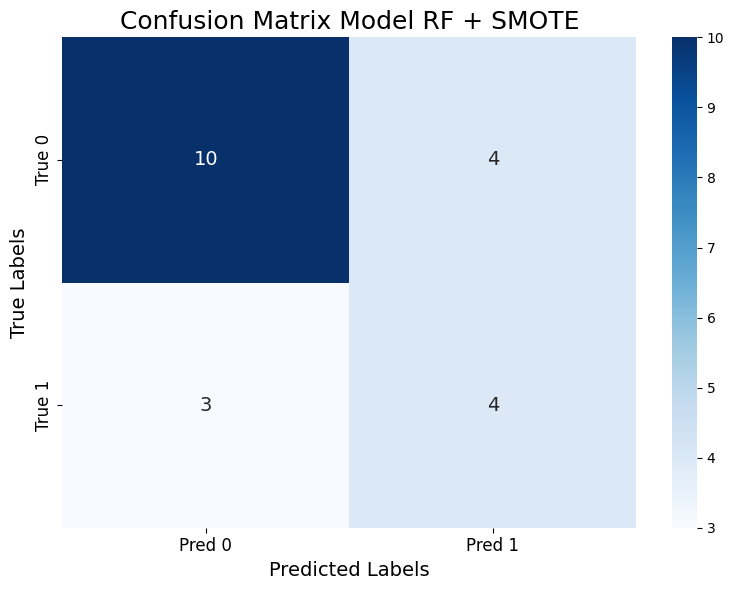


Best Parameters from GridSearchCV (SMOTE):
{'clf__max_depth': 5, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_curve, auc
)

# 1) Siapkan X_test
if hasattr(rf_best_smote, "named_steps"):
    X_test_aligned_smote = X_test
elif hasattr(rf_best_smote, "feature_names_in_"):
    X_test_aligned_smote = X_test.reindex(columns=rf_best_smote.feature_names_in_, fill_value=0)
else:
    X_test_aligned_smote = X_test

# 2) Prediksi & metrik dasar
y_pred_smote = rf_best_smote.predict(X_test_aligned_smote)
acc_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy: {acc_smote:.4f}\n")

labels_sorted = np.sort(np.unique(np.concatenate([np.asarray(y_test), np.asarray(y_pred_smote)])))
print("Classification Report:")
print(classification_report(y_test, y_pred_smote, labels=labels_sorted, zero_division=0))

cm_smote = confusion_matrix(y_test, y_pred_smote, labels=labels_sorted)
print("\nConfusion Matrix (urut label):", labels_sorted)
print(cm_smote)

if cm_smote.shape == (2, 2):
    TN, FP, FN, TP = cm_smote.ravel()
    print(f"\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    sensitivity_smote = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity_smote = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    g_mean_smote = np.sqrt(sensitivity_smote * specificity_smote)
    youden_index_smote = sensitivity_smote + specificity_smote - 1
    print(f"\nG-Mean: {g_mean_smote:.4f}")
    print(f"Youden's Index: {youden_index_smote:.4f}")

#  3) ROC & AUC (binary)
try:
    if len(labels_sorted) == 2:
        POS = labels_sorted[1]
        if hasattr(rf_best_smote, "classes_"):
            pos_idx = np.where(rf_best_smote.classes_ == POS)[0][0]
        else:
            clf = getattr(rf_best_smote, "named_steps", {}).get("clf", None)
            pos_idx = np.where(clf.classes_ == POS)[0][0] if clf is not None else 1

        y_score_smote = rf_best_smote.predict_proba(X_test_aligned_smote)[:, pos_idx]
        fpr, tpr, thresholds = roc_curve(y_test, y_score_smote, pos_label=POS)
        roc_auc_smote = auc(fpr, tpr)
        print(f"AUC: {roc_auc_smote:.4f}")

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc_smote:.4f})')
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)', fontsize=14)
        plt.ylabel('True Positive Rate (TPR)', fontsize=14)
        plt.title('ROC Curve Model RF + SMOTE', fontsize=18)
        plt.legend(loc="lower right", fontsize=12)
        plt.tick_params(axis='both', labelsize=12)
        plt.tight_layout(); plt.show()
except Exception as e:
    print(f"[WARN] ROC/AUC error: {e}")

# 4) Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_smote, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f'Pred {l}' for l in labels_sorted],
    yticklabels=[f'True {l}' for l in labels_sorted],
    annot_kws={"size": 14}
)
plt.title('Confusion Matrix Model RF + SMOTE', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14); plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.tight_layout(); plt.show()

#  5) Best params
try:
    print("\nBest Parameters from GridSearchCV (SMOTE):")
    print(grid_search_smote.best_params_)
except NameError:
    pass

## G. Pelatihan Model Random Forest (RF) Tanpa SMOTE

### 1-Input Data

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data
df = pd.read_excel('/content/Data Meter Update-clean.xlsx', sheet_name='inti')
df.columns = df.columns.astype(str)
df.drop(columns=['No', 'Keterangan', 'Keterangan FIX', 'Total'], inplace=True, errors='ignore')

# Kolom tahun
year_cols = ['2022', '2023', '2024', '2025']
df[year_cols] = df[year_cols].fillna(-1).astype(int)

### 2-Distribusi Nilai Berdasarkan Kondisi

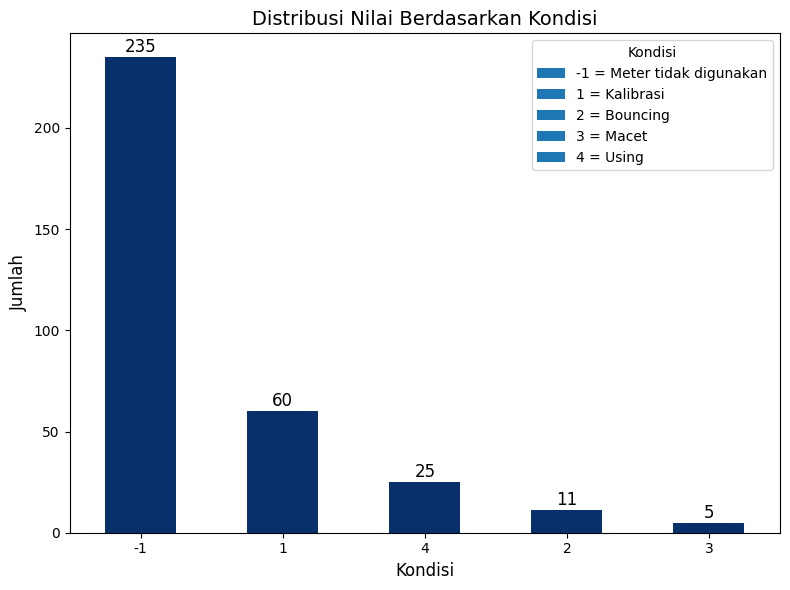

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Ambil semua nilai di kolom tahun dan ubah 0 jadi -1
all_years = df[year_cols].values.flatten()
all_years = np.where(all_years == 0, -1, all_years)  # Ganti 0 jadi -1

# Hitung distribusi nilai setelah penggantian
condition_counts = pd.Series(all_years).value_counts()

# Warna semua biru
bar_color = '#08306b'

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = condition_counts.plot(kind='bar', color=bar_color)

# Menambahkan jumlah di atas setiap bar
for i, v in enumerate(condition_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=12)

# Judul dan label
plt.title('Distribusi Nilai Berdasarkan Kondisi', fontsize=14)
plt.xlabel('Kondisi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(
    ticks=range(len(condition_counts)),
    labels=[str(i) for i in condition_counts.index],  # hanya angka
    rotation=0
)

# Legend dengan keterangan penuh
legend_handles = [
    mpatches.Patch(label='-1 = Meter tidak digunakan'),
    mpatches.Patch(label='1 = Kalibrasi'),
    mpatches.Patch(label='2 = Bouncing'),
    mpatches.Patch(label='3 = Macet'),
    mpatches.Patch(label='4 = Using')
]

plt.legend(handles=legend_handles, title="Kondisi", loc='upper right')
plt.tight_layout()
plt.show()


### 3-Pelabelan Data

In [29]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Format long data
df_long = pd.melt(
    df,
    id_vars=['MERK METER', 'JENIS meter', 'TAHUN meter', 'G SIZE meter', 'DIA. (inchi) meter', 'SERIAL NUMBER meter'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Condition'
)

df_long['Year'] = df_long['Year'].astype(int)
df_long['Usia Meter'] = df_long['Year'] - df_long['TAHUN meter']

# Inisialisasi OneHotEncoder
ohe_merk = OneHotEncoder()
ohe_jenis = OneHotEncoder()
ohe_gsize = OneHotEncoder()

# Melakukan One-Hot Encoding pada kolom kategori di df
merk_encoded = ohe_merk.fit_transform(df[['MERK METER']])
jenis_encoded = ohe_jenis.fit_transform(df[['JENIS meter']])
gsize_encoded = ohe_gsize.fit_transform(df[['G SIZE meter']])

# Membuat DataFrame dari hasil encoding
df_merk = pd.DataFrame(merk_encoded.toarray(), columns=ohe_merk.get_feature_names_out(['MERK METER']))
df_jenis = pd.DataFrame(jenis_encoded.toarray(), columns=ohe_jenis.get_feature_names_out(['JENIS meter']))
df_gsize = pd.DataFrame(gsize_encoded.toarray(), columns=ohe_gsize.get_feature_names_out(['G SIZE meter']))

# Gabungkan hasil One-Hot Encoding ke df
df = pd.concat([df, df_merk, df_jenis, df_gsize], axis=1)

# Gabungkan kolom yang sudah di-encode ke df_long
df_long = df_long.merge(df[['MERK METER', 'JENIS meter', 'G SIZE meter'] + list(df_merk.columns) + list(df_jenis.columns) + list(df_gsize.columns)],
                        on=['MERK METER', 'JENIS meter', 'G SIZE meter'], how='left')

# Menampilkan data setelah digabungkan
print(df_long.head())


  MERK METER JENIS meter  TAHUN meter  G SIZE meter  DIA. (inchi) meter  \
0    ITRON      Rotary           2016            25                   2   
1    ITRON      Rotary           2016            25                   2   
2    ITRON      Rotary           2016            25                   2   
3    ITRON      Rotary           2016            25                   2   
4    ITRON      Rotary           2016            25                   2   

  SERIAL NUMBER meter  Year  Condition  Usia Meter  MERK METER_ACTARIS    ...  \
0       '3402824608    2022          1           6                   0.0  ...   
1       '3402824608    2022          1           6                   0.0  ...   
2       '3402824608    2022          1           6                   0.0  ...   
3       '3402824608    2022          1           6                   0.0  ...   
4       '3402824608    2022          1           6                   0.0  ...   

   G SIZE meter_25  G SIZE meter_40  G SIZE meter_65  G SIZE m

### 4-Menjadikan Label Biner

In [30]:
# Gabungkan 2 & 3 jadi 2 (anomaly)
for col in year_cols:
    df[col] = df[col].replace({3: 2})

# Ubah nilai 4 menjadi -1 karena tidak digunakan
for col in year_cols:
    df[col] = df[col].replace({4: -1})

### 5-Distribusi Kelas per Meter

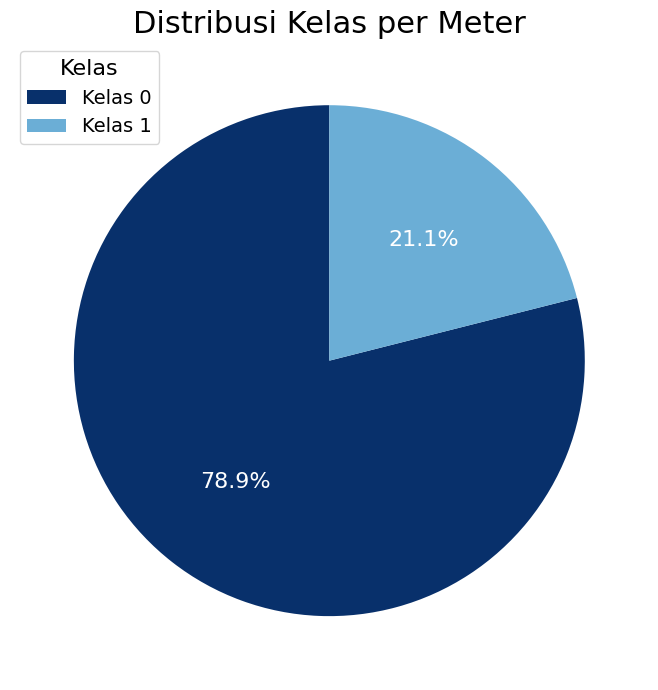

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
colors = ['#08306b', '#6baed6']   # Warna untuk kelas 0 dan 1
wedges, texts, autotexts = plt.pie(
    kelas_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Atur style persentase di pie chart
for a in autotexts:
    a.set_color('white')
    a.set_fontsize(16)   # perbesar ukuran persentase tanpa bold

# Tambahkan legenda dengan ukuran lebih besar
plt.legend(
    wedges,
    ['Kelas 0', 'Kelas 1'],
    title="Kelas",
    loc="best",
    fontsize=14,        # ukuran teks legenda
    title_fontsize=16   # ukuran judul legenda
)

# Judul lebih besar (tanpa bold)
plt.title("Distribusi Kelas per Meter", fontsize=22)

plt.tight_layout()
plt.show()

### 6-Pembagian Data Latih dan Data Uji Model RF

In [32]:
from sklearn.model_selection import train_test_split

# Membuat kolom 'Kelas' untuk kategori Baik (0) dan Anomali (1)
df['Kelas'] = df[year_cols].apply(lambda row: 0 if row.isin([1]).any() else 1, axis=1)

# Pisahkan fitur dan target
X = df[['usia', 'TAHUN meter', 'DIA. (inchi) meter'] + list(df_merk.columns) + list(df_jenis.columns) + list(df_gsize.columns) + year_cols]  # Fitur
#X = df[['usia', 'TAHUN meter', 'DIA. (inchi) meter'] + list(df_merk.columns) + list(df_jenis.columns) + list(df_gsize.columns)]  # Fitur
y = df['Kelas']    # Target (kolom kelas yang sudah dibuat)

# Membagi data menjadi 80% latih dan 20% uji secara stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Menampilkan jumlah data latih dan data uji
print(f'Jumlah data latih: {len(X_train)}')
print(f'Jumlah data uji: {len(X_test)}')

# Menampilkan distribusi per kelas untuk data latih dan data uji
print("\nDistribusi Kelas pada Data Latih:")
print(y_train.value_counts())

print("\nDistribusi Kelas pada Data Uji:")
print(y_test.value_counts())


Jumlah data latih: 63
Jumlah data uji: 21

Distribusi Kelas pada Data Latih:
Kelas
0    41
1    22
Name: count, dtype: int64

Distribusi Kelas pada Data Uji:
Kelas
0    14
1     7
Name: count, dtype: int64


### 7-Cek Duplikasi Data

In [33]:
# Mengecek duplikat pada dataset
duplicates = df[df.duplicated()]

# Menampilkan data duplikat
print("Jumlah data duplikat:", len(duplicates))
print(duplicates)


Jumlah data duplikat: 0
Empty DataFrame
Columns: [MERK METER, JENIS meter, TAHUN meter, G SIZE meter, DIA. (inchi) meter, SERIAL NUMBER meter, 2022, 2023, 2024, 2025, Kondisi Meter, usia, MERK METER_ACTARIS  , MERK METER_CANGNAN  , MERK METER_CNIM  , MERK METER_DRESSER  , MERK METER_ELSTER  , MERK METER_ITRON  , MERK METER_RMG  , MERK METER_VEMTEC  , MERK METER_VEMTECH  , JENIS meter_Diapfragma  , JENIS meter_Rotary  , JENIS meter_Turbin  , G SIZE meter_16, G SIZE meter_25, G SIZE meter_40, G SIZE meter_65, G SIZE meter_100, G SIZE meter_160, G SIZE meter_250, G SIZE meter_400, G SIZE meter_650, G SIZE meter_1600, G SIZE meter_2500, Kelas]
Index: []

[0 rows x 36 columns]


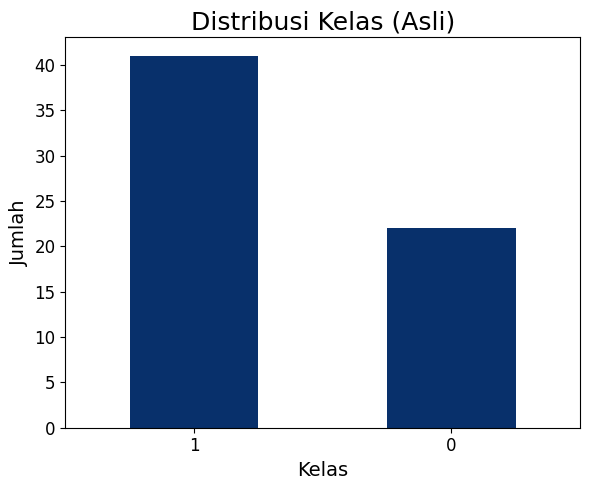

In [34]:
import matplotlib.pyplot as plt

# Menampilkan distribusi per kelas tanpa SMOTE
plt.figure(figsize=(6, 5))
y_train.value_counts().plot(kind='bar', color='#08306b')

# perbesar teks judul & label
plt.title('Distribusi Kelas (Asli)', fontsize=18)   # judul lebih besar
plt.xlabel('Kelas', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)

# perbesar label sumbu x
plt.xticks(
    ticks=range(len(y_train.unique())),
    labels=y_train.unique(),
    rotation=0,
    fontsize=12
)

# perbesar label sumbu y
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

### 8-Pelatihan Model RF Tanpa SMOTE

In [36]:
import time
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

### 9-Uji OOB (Opsional)

In [37]:
classifier_rf.oob_score_

0.7619047619047619

### 10-Hyperparameter Tuning Model RF Tanpa SMOTE

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

rf = RandomForestClassifier(n_jobs=-1, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8, 12, None],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 0.5],
    'class_weight': [None, 'balanced']   # penting saat tanpa SMOTE
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',      # kalau imbalance, pertimbangkan 'f1' atau 'roc_auc' (binary)
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("CV best score:", grid_search.best_score_)
rf_best = grid_search.best_estimator_


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best params: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
CV best score: 0.7948717948717949


### 11-Parameter Terbaik Model RF

In [42]:
print(rf_best)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.5,
                       min_samples_leaf=2, n_estimators=300, n_jobs=-1,
                       random_state=42)


### 12-Contoh Pohon Keputusan yang Terbentuk dari Model RF

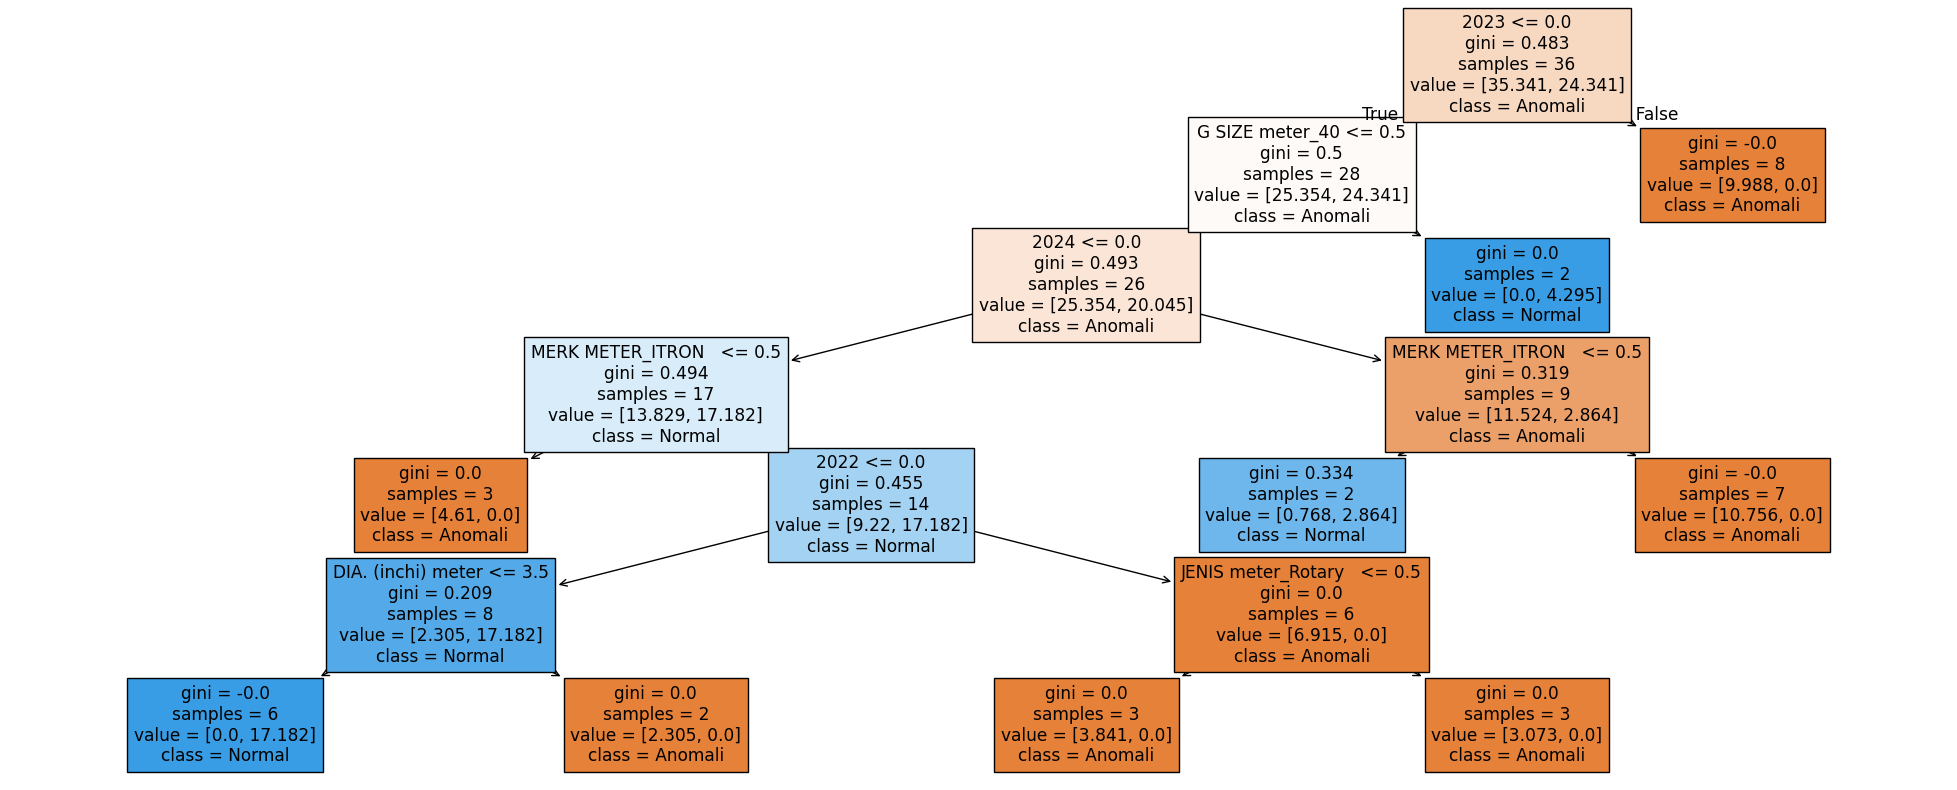

In [43]:
#Melihat Decision Tree dengan n_estimator = 100
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))
plot_tree(rf_best.estimators_[100], feature_names = X.columns,class_names=['Anomali', "Normal"],filled=True);

### 13-Evaluasi Model RF

Accuracy: 0.7619

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.62      0.71      0.67         7

    accuracy                           0.76        21
   macro avg       0.74      0.75      0.74        21
weighted avg       0.77      0.76      0.77        21


Confusion Matrix:
[[11  3]
 [ 2  5]]

TP: 5, TN: 11, FP: 3, FN: 2

G-Mean: 0.7491
Youden's Index: 0.5000
AUC: 0.7245


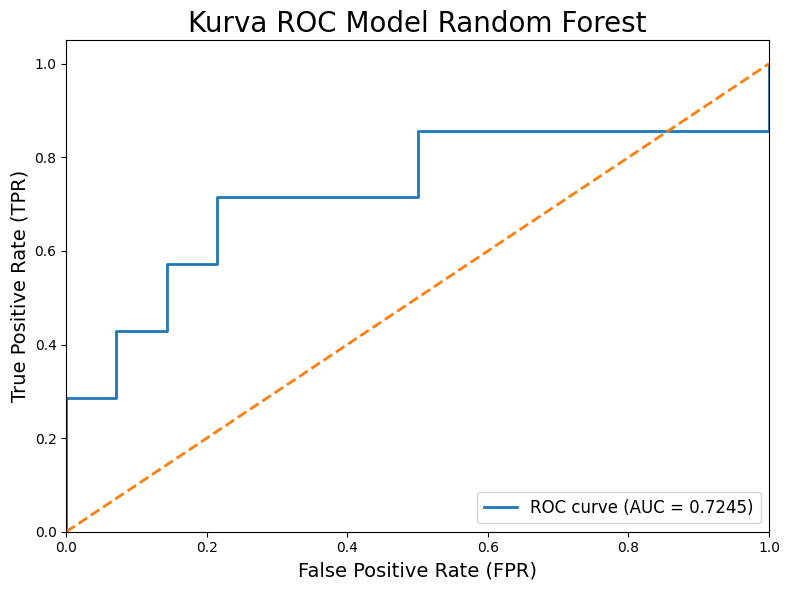

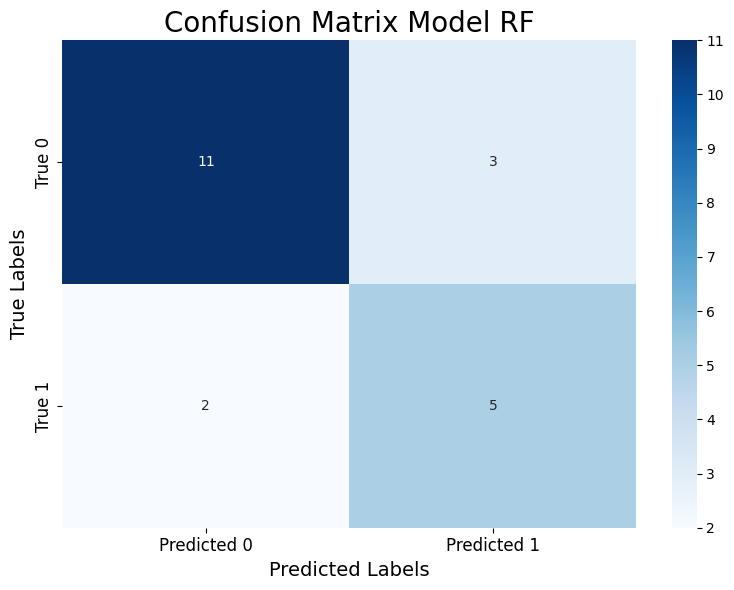


Best Parameters from GridSearchCV:
{'class_weight': 'balanced', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Top 10 Feature Importances:
               Feature  Importance
28                2024    0.162094
26                2022    0.149597
1          TAHUN meter    0.144075
0                 usia    0.125541
27                2023    0.103883
29                2025    0.074727
9     MERK METER_RMG      0.070137
16     G SIZE meter_25    0.035094
2   DIA. (inchi) meter    0.033463
8   MERK METER_ITRON      0.025228


In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# pastikan rf_best ada
try:
    rf_best
except NameError:
    rf_best = grid_search.best_estimator_

# samakan kolom X_test dengan yang diharapkan model
if hasattr(rf_best, "feature_names_in_"):
    expected_cols = rf_best.feature_names_in_
    X_test_aligned = X_test.reindex(columns=expected_cols, fill_value=0)
else:
    # Jika rf_best adalah Pipeline, dia akan urus transform-nya sendiri
    X_test_aligned = X_test

# prediksi
y_pred = rf_best.predict(X_test_aligned)

# Evaluasi dasar
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Ekstrak TP, TN, FP, FN
TP = cm[1, 1]; TN = cm[0, 0]; FP = cm[0, 1]; FN = cm[1, 0]
print(f"\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# G-Mean & Youden's Index
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
g_mean = np.sqrt(sensitivity * specificity)
youden_index = sensitivity + specificity - 1
print(f"\nG-Mean: {g_mean:.4f}")
print(f"Youden's Index: {youden_index:.4f}")

# ROC & AUC (gunakan predict_proba bila ada)
if hasattr(rf_best, "predict_proba"):
    y_score = rf_best.predict_proba(X_test_aligned)[:, 1]
else:
    # fallback: decision_function bila tersedia
    y_score = rf_best.decision_function(X_test_aligned)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Kurva ROC Model Random Forest', fontsize=20)  # judul diperbesar
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()


# Heatmap Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix Model RF', fontsize=20)  # judul diperbesar
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Best params (kalau ada grid_search)
try:
    print("\nBest Parameters from GridSearchCV:")
    print(grid_search.best_params_)
except NameError:
    pass

# Feature importance + nama fitur (mendukung model biasa & Pipeline)
feat_names = None
feat_importances = None

if hasattr(rf_best, "named_steps"):
    # Pipeline: ambil preprocessor dan clf
    clf = rf_best.named_steps.get('clf', None)
    prep = rf_best.named_steps.get('prep', None)
    if clf is not None and hasattr(clf, "feature_importances_"):
        feat_importances = clf.feature_importances_
        if prep is not None and hasattr(prep, "get_feature_names_out"):
            feat_names = prep.get_feature_names_out()
elif hasattr(rf_best, "feature_importances_"):
    feat_importances = rf_best.feature_importances_
    # coba gunakan kolom training yang diingat model
    if hasattr(rf_best, "feature_names_in_"):
        feat_names = rf_best.feature_names_in_
    else:
        feat_names = X_test_aligned.columns

if feat_importances is not None and feat_names is not None:
    feature_importance_df = pd.DataFrame({
        'Feature': feat_names,
        'Importance': feat_importances
    }).sort_values('Importance', ascending=False)
    print("\nTop 10 Feature Importances:")
    print(feature_importance_df.head(10))
else:
    print("\nFeature importances tidak tersedia untuk estimator ini atau nama fitur tidak dapat diambil.")


## H. Perbandingan Dua Model Klasifikasi
1. Model RF + SMOTE
2. Model RF

### 1-Visualisasi Perbandingan Model Klasifikasi

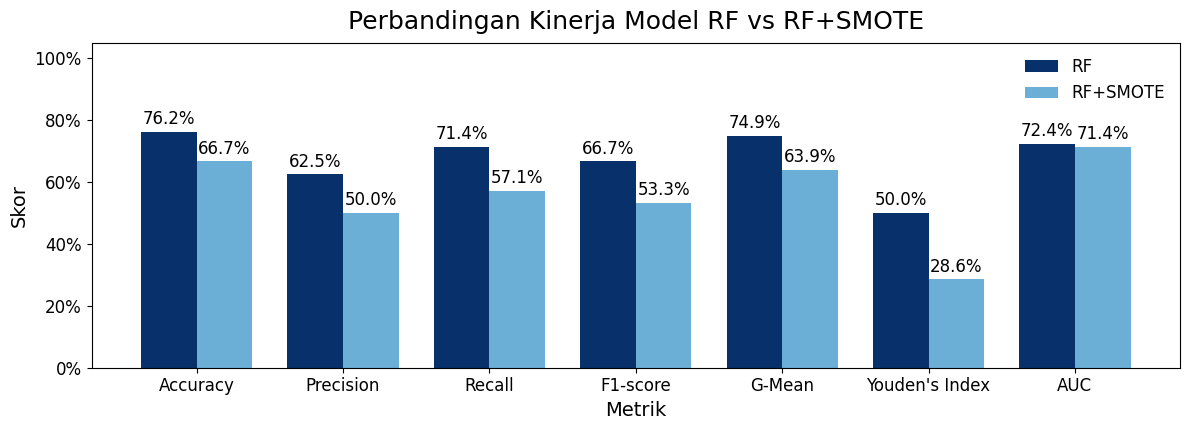

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 1) MASUKKAN ANGKA MANUAL HASIL DARI PEMODELAN
metrics_rf = {
    "Model": "RF",
    "Accuracy": 0.762,
    "Precision": 0.625,
    "Recall": 0.714,
    "F1-score": 0.667,
    "G-Mean": 0.749,
    "Youden's Index": 0.500,
    "AUC": 0.724
}

metrics_smote = {
    "Model": "RF+SMOTE",
    "Accuracy": 0.667,
    "Precision": 0.500,
    "Recall": 0.571,
    "F1-score": 0.533,
    "G-Mean": 0.639,
    "Youden's Index": 0.286,
    "AUC": 0.714
}

# gabungkan ke DataFrame
res_df = pd.DataFrame([metrics_rf, metrics_smote])

# 2) PLOT BAR CHART
order = ["Accuracy","Precision","Recall","F1-score","G-Mean","Youden's Index","AUC"]
res_plot = res_df.set_index("Model")[order].copy()

color_rf    = '#08306b'  # biru tua
color_smote = '#6baed6'  # biru muda

x = np.arange(len(order))
width = 0.38

fig, ax = plt.subplots(figsize=(12, 4.4))

bars1 = ax.bar(x - width/2, res_plot.loc["RF"].values,        width, label="RF",        color=color_rf)
bars2 = ax.bar(x + width/2, res_plot.loc["RF+SMOTE"].values,  width, label="RF+SMOTE",  color=color_smote)

# label persen di atas bar
def annotate(bars):
    for b in bars:
        h = b.get_height()
        if np.isnan(h):
            continue
        ax.text(b.get_x() + b.get_width()/2, h + 0.012, f"{h*100:.1f}%",
                ha="center", va="bottom", fontsize=12)  # teks diperbesar

annotate(bars1); annotate(bars2)

ax.set_xticks(x, order)
ax.set_ylim(0, 1.05)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylabel("Skor", fontsize=14)
ax.set_xlabel("Metrik", fontsize=14)
ax.set_title("Perbandingan Kinerja Model RF vs RF+SMOTE", fontsize=18, pad=10)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()

### 2-Perbandingan CV best (5-fold, accuracy) Pada Model Klasifikasi

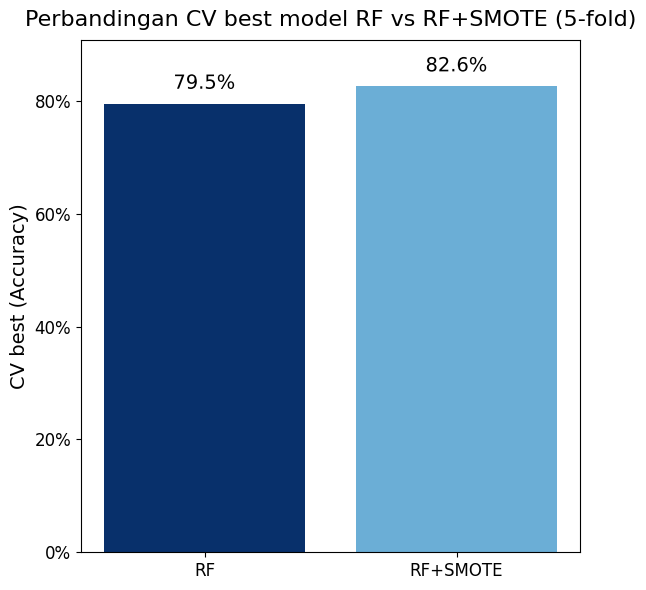

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patheffects as pe

cv_rf    = 0.7948717948717949
cv_smote = 0.8256410256410257

labels = ["RF", "RF+SMOTE"]
scores = [cv_rf, cv_smote]
colors = ['#08306b', '#6baed6']

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(6,6))
bars = ax.bar(x, scores, color=colors)

# anotasi di atas bar
for rect, val in zip(bars, scores):
    ax.annotate(f"{val*100:.1f}%",
                (rect.get_x() + rect.get_width()/2, rect.get_height()),
                xytext=(0, 8), textcoords="offset points",  # offset ke atas
                ha="center", va="bottom", fontsize=14, color="black",  # font diperbesar
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])

ax.set_xticks(x, labels, fontsize=12)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, max(scores)*1.10)
ax.set_ylabel("CV best (Accuracy)", fontsize=14)
ax.set_title("Perbandingan CV best model RF vs RF+SMOTE (5-fold)", fontsize=16, pad=10)
ax.tick_params(axis='y', labelsize=12)

fig.tight_layout()
plt.show()

### 3-Perbandingan Waktu Pelatihan Model Klasifikasi

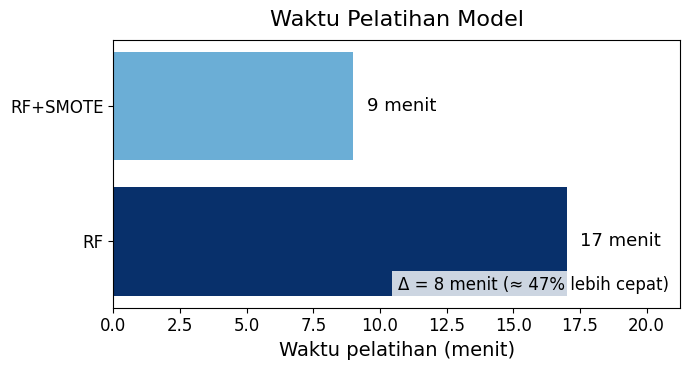

In [47]:
import matplotlib.pyplot as plt

# data waktu (menit)
t_rf = 17
t_smote = 9

labels = ["RF", "RF+SMOTE"]
times  = [t_rf, t_smote]
colors = ['#08306b', '#6baed6']  # warna yang kamu minta

fig, ax = plt.subplots(figsize=(7, 3.8))
bars = ax.barh(labels, times, color=colors)

# label "X menit" di ujung bar
for bar, t in zip(bars, times):
    ax.text(t + 0.5, bar.get_y()+bar.get_height()/2, f"{t} menit",
            va='center', fontsize=13)  # diperbesar

# anotasi selisih & speed-up
delta = t_rf - t_smote                 # 8 menit
pct   = delta / t_rf * 100             # ~47%
ax.text(0.98, 0.05,
        f"Δ = {delta} menit (≈ {pct:.0f}% lebih cepat)",
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax.set_xlabel("Waktu pelatihan (menit)", fontsize=14)
ax.set_xlim(0, max(times)*1.25)
ax.set_title("Waktu Pelatihan Model", fontsize=16, pad=10)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()